# 0. Introduction

Assume we have all our raw data cleaned and expert variables created, we can start the unsupervised fraud analysis.

Since we understand there's no reliable labels for us to determine the quality of our algorithms by cost functions (which is the definition of `unsupervised learning`), we set the goal to our algorithm to be finding outliers.

To do so, we need to define a statistics (統計量) to quantitatively measure which observation is `normal` and which is `abnormal`. 

We choose `Mahattan distance`, `Euclidean disdance` and `autoencoder` as our statistics, and combine the output of these three algorithms to decide the extent of `anomaly` by quantitle to select those potential fraud cases.

# 1. PCA

Now we have the dataset of `45` expert variables with `1048575` observations. To avoid the `curse of dimensionality`, we need to perform `dimensionality reduction` (usually the number of `dimensionality` refers to the number of `variables`, here `45`).  

We choose `PCA` to perform dimensionality reduction. The idea of `PCA` is to create new variables that are linear combinations of existing variables, which explain most `variances` using far less variables than the original dataset contains (or based on ISLR: an approach for deriving a low-deimensional set of features from a large set of variables).

To perform `PCA` we need the following steps (or not if we have built-in functions...):

1. build `covariance matrix`
2. decompose the `covariance matrix` into `eigenvectors`(特徵向量) and `eigenvalues`(特徵值)
3. choose `k` biggest `eigenvalues` and corresponding `eigenvectors`, where `k` is the dimensionality of new `feature spcae` and `k<=45` in our case.
4. use the `k` `eigenvectors` to build `project matrix`(投影矩陣)
5. use the `project matrix` to transform the original `45` dimensions dataset into `k` dimensions dataset

----------------------以下碎念-----------------------------

Note that despite the fact we understand the result of `PCA` is generally lame in interpretability, we still have to carefully pick our expert variables. For instance, we don't use `FULLVAL`, `AVTOT`, `AVLAND` directly as our expert variable, but use their derivatives. The rationale behind this decision is that even if we can find outliers of `FULLVAL`, `AVTOT`, `AVLAND`, we cannot justify their relationship to potential frauds - an outlier of `FULLVAL` can be a very expensive property (which is something expected), while an outlier of our set of expert variables, is a very expensive/ cheap property with respect to `tax class`, `exemptions`, `property volumns`  etc.

### 1. covariance matrix

In [4]:
import numpy as np 
import pandas as pd
import os

In [5]:
path = os.getcwd()+'/'

In [70]:
data = pd.read_csv(path+'data_newvariables.csv')

By transposing the matrix columns won't be droppped... somthing trivial but helpful I guess...

we learned that the first column is the record, we'll drop it later.

In [4]:
data.T.head(len(data.columns))

,0,1,2,3,4,5,6,7,8,9,...,1048565,1048566,1048567,1048568,1048569,1048570,1048571,1048572,1048573,1048574
Unnamed: 0,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,...,1.048566e+06,1.048567e+06,1.048568e+06,1.048569e+06,1.048570e+06,1.048571e+06,1.048572e+06,1.048573e+06,1.048574e+06,1.048575e+06
FULLVAL,-0.040459,-0.039775,-0.064299,-0.065614,-0.075237,-0.025505,-0.029180,-0.039690,-0.018840,-0.015252,...,-7.523653e-02,-5.298227e-02,-3.311032e-02,-7.396335e-02,-4.353506e-02,-3.584468e-02,-7.238861e-02,-5.623240e-02,-4.741349e-03,-3.225583e-02
AVLAND,-0.017962,-0.017727,-0.020951,-0.020497,-0.020971,-0.016629,-0.013421,-0.017565,-0.017455,-0.016559,...,-2.097053e-02,-2.076277e-02,-1.658281e-02,-1.933547e-02,-2.051354e-02,-2.059134e-02,-1.978368e-02,-1.952104e-02,-1.698493e-02,-1.054562e-02
AVTOT,-0.030386,-0.030131,-0.033185,-0.032918,-0.033197,-0.028901,0.001696,-0.029982,-0.027721,-0.028928,...,-3.319686e-02,-3.184932e-02,-2.908030e-02,-3.223228e-02,-2.479040e-02,-2.678933e-02,-3.103924e-02,-1.879907e-02,-2.892422e-02,-6.341609e-04
NA_COUNT_PRE,-0.438286,0.221827,2.202163,2.202163,1.542051,0.881939,-0.438286,0.881939,0.881939,0.221827,...,1.542051e+00,8.819388e-01,2.218265e-01,-2.418622e+00,8.819388e-01,8.819388e-01,-1.758510e+00,-1.758510e+00,2.218265e-01,-4.382857e-01
NA_COUNT_POST,-2.683409,-0.750185,1.183039,1.183039,-0.750185,1.183039,1.183039,1.183039,1.183039,-0.750185,...,1.183039e+00,1.183039e+00,-7.501847e-01,-4.616633e+00,1.183039e+00,1.183039e+00,-7.501847e-01,-7.501847e-01,-7.501847e-01,1.183039e+00
FULLVAL_LTAREA_zip5,-0.216048,-0.732898,0.273146,-1.215754,0.451671,0.190524,-0.508407,-0.171486,-0.245040,0.528207,...,6.219055e-01,-7.770219e-01,-7.328979e-01,-1.106309e+00,3.964051e-01,4.497497e-01,-1.406728e+00,2.135620e+00,4.608278e-02,4.268190e-01
FULLVAL_BLDAREA_zip5,-0.307669,-0.207470,0.825740,2.547374,1.399349,0.616300,-0.250387,-0.238987,0.298369,0.350750,...,-5.687304e-01,-3.929417e-01,-2.074702e-01,-1.316875e-01,1.654956e-01,-7.490398e-02,-1.333131e+00,1.145490e-01,7.230464e-01,-1.590091e-01
FULLVAL_VOLUME_zip5,-0.032175,0.237211,0.503424,1.301265,2.717538,0.535071,-0.148134,0.122591,0.414847,0.511093,...,-9.681709e-01,-3.533859e-02,2.372106e-01,1.412704e-01,1.657344e-01,-3.393940e-01,-1.176868e+00,-9.896706e-01,1.574798e+00,-2.667215e-01
AVLAND_LTAREA_zip5,-0.315699,-0.488281,0.746742,-0.076495,2.732278,-0.133411,-0.386666,-0.150816,-0.358444,-0.212623,...,6.906858e-01,-5.276460e-01,-4.882808e-01,-5.296532e-01,-3.132295e-01,-3.549090e-01,-6.224955e-01,4.494831e+00,-2.197491e-01,-3.412561e-01


In [71]:
data = data.iloc[:,1:]

Since `PCA` is sensitive to scale (for `PCA` is finding the linear combinations of vriables that explains the most `variations` in the existing dataset, if one variable scales 100 times to other variables, most variances will be defined based on that variable), we have to make sure our expert variables are standardized.

In [72]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
FULLVAL,1048575.0,1.666962e-18,1.0,-0.075237,-0.049346,-0.037126,-0.022344,525.434322
AVLAND,1048575.0,2.303932e-19,1.0,-0.020971,-0.018737,-0.017643,-0.016165,650.712812
AVTOT,1048575.0,6.505219e-19,1.0,-0.033197,-0.030552,-0.029552,-0.026566,671.549397
NA_COUNT_PRE,1048575.0,-2.739172e-16,1.0,-3.738847,-0.438286,0.221827,0.881939,3.522388
NA_COUNT_POST,1048575.0,4.389397e-16,1.0,-4.616633,-0.750185,-0.750185,1.183039,1.183039
FULLVAL_LTAREA_zip5,1048575.0,-9.093212e-16,1.0,-1.701303,-0.608927,-0.205564,0.273146,37.947758
FULLVAL_BLDAREA_zip5,1048575.0,5.879295e-16,1.0,-1.606806,-0.324807,-0.080519,0.312632,710.573983
FULLVAL_VOLUME_zip5,1048575.0,-9.154741e-17,1.0,-1.519972,-0.324093,0.033605,0.362558,462.390507
AVLAND_LTAREA_zip5,1048575.0,-6.224580e-16,1.0,-0.675876,-0.430011,-0.323012,-0.150816,46.925182
AVLAND_BLDAREA_zip5,1048575.0,-1.260386e-16,1.0,-0.544658,-0.336131,-0.263921,-0.079700,217.196467


Now we know our dataset has been taken cared of well, probably by gentle hands, we can build the `covariance matrix`.

Note that if we don't specify `rowvar=False`, `np.cov` by default will treat the rows as variables.

In [73]:
cov_mat = np.cov(data,rowvar=False)

In [74]:
cov_mat.shape

(65, 65)

### 2. eigenvalues and eigenvectors

We have a handy function `np.linalg.eig` which stands for `linear algebra . eigen`  to derive `eigenvalues` and `eigenvectors`

In [75]:
eigen_vals,eigen_vecs = np.linalg.eig(cov_mat)

In [76]:
eigen_vals

array([ 1.91110229e+01,  1.20422652e+01,  8.53500583e+00,  6.74526295e+00,
        4.26064362e+00,  2.58459227e+00,  2.20966126e+00,  1.82454371e+00,
        1.65830725e+00,  1.35958562e+00,  8.24524037e-01,  6.96944410e-01,
        6.64956786e-01,  5.04224279e-01,  4.22754604e-01,  2.89932123e-01,
        2.54257256e-01,  2.14948175e-01,  1.51382413e-01,  1.44436505e-01,
        9.37391037e-02,  8.92062424e-02,  7.10727376e-02,  6.03643533e-02,
        4.61086148e-02,  4.44324213e-02,  2.63123621e-02,  2.32342107e-02,
        1.68150202e-02,  1.19964021e-02,  5.96863145e-03,  3.16418530e-03,
        1.99456615e-03,  1.86220008e-03,  1.47532165e-03,  1.19034289e-03,
        6.28080105e-04,  5.23009727e-04,  2.99936437e-04,  2.51518442e-04,
        5.32358067e-05,  2.98713623e-05,  1.13745030e-05,  9.79927497e-06,
        2.96698889e-06,  1.08838852e-06,  7.91840416e-07,  3.72990383e-07,
        5.88245616e-08,  1.03534377e-08,  9.33726310e-09, -1.05005020e-13,
        9.16198054e-14, -

In [77]:
eigen_vecs

array([[-1.77019850e-02, -6.15023913e-04,  2.43067903e-02, ...,
         4.35879510e-13, -5.46308331e-13, -4.18484778e-14],
       [-9.62735164e-03, -1.01506544e-03,  1.81068861e-02, ...,
        -5.73530070e-13,  7.19997047e-13,  5.22413619e-14],
       [-1.47997082e-02, -1.16770968e-03,  2.30588189e-02, ...,
         3.56951510e-13, -4.48062316e-13, -3.21363629e-14],
       ...,
       [ 8.44653580e-04,  2.86307680e-01,  3.20555048e-02, ...,
        -3.58912470e-04, -3.92505057e-04, -4.49018848e-04],
       [ 8.60687542e-04,  2.82759412e-01,  3.20526321e-02, ...,
        -2.74731319e-05, -4.07613605e-05, -4.88654690e-05],
       [ 8.54262339e-04,  2.84145823e-01,  3.20887874e-02, ...,
         3.22194687e-04,  4.05471737e-04,  4.92150628e-04]])

In [78]:
eigen_vecs.shape

(65, 65)

### 3. PCs

Here we try to find the `PC`s that explains the most `variances`.

In [67]:
import matplotlib.pyplot as plt

In [79]:
tot = sum(eigen_vals)
var_explained = [(i/tot) for i in sorted(eigen_vals,reverse = True)]
cum_var_explained = np.cumsum(var_explained)

By looking at the cumulated variance explained, we learn that the first `PC` explains `26.3%` of `variance`, and top 10 `PCs` explain `95.7%` of `variance`.

In [80]:
cum_var_explained

array([0.29401574, 0.47928135, 0.61058914, 0.71436241, 0.77991078,
       0.81967373, 0.85366852, 0.88173843, 0.90725085, 0.92816755,
       0.94085253, 0.95157475, 0.96180486, 0.96956216, 0.97606607,
       0.98052657, 0.98443822, 0.98774511, 0.99007407, 0.99229617,
       0.99373831, 0.99511072, 0.99620414, 0.99713282, 0.99784219,
       0.99852576, 0.99893057, 0.99928802, 0.99954671, 0.99973127,
       0.9998231 , 0.99987178, 0.99990246, 0.99993111, 0.99995381,
       0.99997212, 0.99998178, 0.99998983, 0.99999444, 0.99999831,
       0.99999913, 0.99999959, 0.99999977, 0.99999992, 0.99999996,
       0.99999998, 0.99999999, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [81]:
len(cum_var_explained[cum_var_explained<0.9])

8

In [82]:
len_vars = len(cum_var_explained)

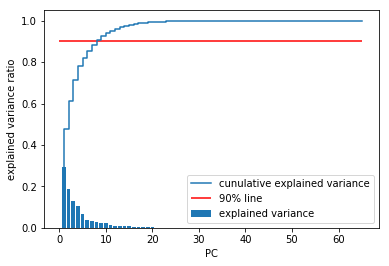

In [83]:
plt.bar(range(1,len_vars+1),var_explained,label = 'explained variance')
plt.step(range(1,len_vars+1),cum_var_explained,label = 'cunulative explained variance')
plt.ylabel('explained variance ratio')
plt.xlabel('PC')
plt.hlines(y=0.90,xmin = 0, xmax=len_vars,label='90% line',colors='red')
plt.legend(loc='best')
plt.show()

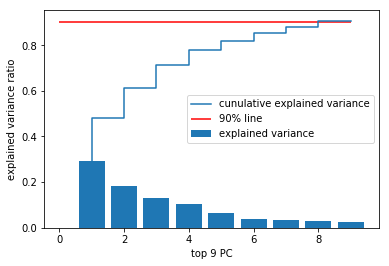

In [84]:
plt.bar(range(1,10),var_explained[:9],label = 'explained variance')
plt.step(range(1,10),cum_var_explained[:9],label = 'cunulative explained variance')
plt.ylabel('explained variance ratio')
plt.xlabel('top 9 PC')
plt.hlines(y=0.90,xmin = 0, xmax=9,label='90% line',colors='red')
plt.legend(loc='best')
plt.show()

### 4. project matrix

It's a little bit convoluting here, but each `eigen_pair` is just the pair of `eigenvalues` and the corresponding `eigenvectors`, sorted by the absolute value of `eigenvalues`.

In [26]:
eigen_pairs = [(np.abs(eigen_vals[i]),eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(reverse = True)

Again a little bit convoluting here. What `np.newaxis` does is to create a new dimension. In our case, we have `eigen_pairs[i][1]` for i in range(0,45) as the `eigenvectors`, with type `numpy.ndarray` and shape `(45,)`. By creating new dimension the array shape becomes `(45,1)`.

Here we choose the top `9` `PCs` which explains `90%` of `variances`.

In [27]:
w = np.hstack((eigen_pairs[0][1][:,np.newaxis],
              eigen_pairs[1][1][:,np.newaxis],
              eigen_pairs[2][1][:,np.newaxis],
              eigen_pairs[3][1][:,np.newaxis],
              eigen_pairs[4][1][:,np.newaxis],
              eigen_pairs[5][1][:,np.newaxis],
              eigen_pairs[6][1][:,np.newaxis],
              eigen_pairs[7][1][:,np.newaxis],
              eigen_pairs[8][1][:,np.newaxis]))

In [28]:
w.shape #w is the project matrix

(65, 9)

### 5. new data set

Do the matrix multiplication

In [29]:
data_pca = data.dot(w)

In [30]:
data_pca.shape

(1048575, 9)

In [31]:
data_pca.head()

,0,1,2,3,4,5,6,7,8
0,2.153382,0.263105,-0.508309,-1.809538,0.400626,-0.152992,0.780353,-0.925072,0.155765
1,3.232429,0.225123,-0.428393,-1.050446,0.375657,-0.086811,-0.927334,0.938315,-0.592509
2,0.954476,-0.033654,-1.334470,0.050955,4.737852,0.447336,0.334439,-1.080460,1.073894
3,-0.275818,-0.534868,-2.081560,7.728822,7.324802,0.847029,-2.749738,-0.116712,1.176933
4,-10.808513,-55.229995,-10.713583,2.445485,5.591622,0.903908,-1.059550,1.690092,5.040414


In [32]:
data_pca.describe()

,0,1,2,3,4,5,6,7,8
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,-9.359357e-15,-5.312514e-14,-3.214446e-15,-1.812609e-14,1.953463e-15,5.028467e-16,-1.058605e-14,1.470611e-14,9.004917e-16
std,4.371616e+00,3.470197e+00,2.921473e+00,2.597164e+00,2.064133e+00,1.607667e+00,1.486493e+00,1.350757e+00,1.287753e+00
min,-1.414950e+02,-5.982412e+01,-1.671939e+01,-6.818438e+00,-6.924593e+00,-8.991279e+02,-4.772648e+01,-8.350749e+01,-3.338101e+02
25%,3.947789e-01,2.169258e-01,-1.312272e+00,-1.695262e+00,-1.260907e+00,-1.046125e-01,-9.362976e-01,-6.186899e-01,-4.935854e-01
50%,1.839182e+00,3.129153e-01,-4.980342e-01,-1.050432e+00,1.489163e-01,-3.288082e-02,2.168109e-02,9.904528e-02,-9.222451e-02
75%,2.183649e+00,3.716235e-01,-3.554330e-01,1.831540e+00,8.493540e-01,9.234570e-02,1.215411e+00,7.344582e-01,5.487921e-01
max,1.788955e+01,2.767465e+01,6.383324e+01,3.477139e+02,6.376547e+02,2.680240e+01,6.532741e+01,1.109098e+02,9.388237e+01


We  can save the result of PCA for future use.

In [33]:
data_pca.to_csv(path+'data_pca.csv')

# 2. Distances

Here we try to use our output from PCA to quantify the extent of deviation of a certain observation. The method we choose is calculating the `Mahattan Distance` and `Euclidean Distance` of each observation from `origin`. 

To do so we measure

$$ S = (\sum_{i} | Z_i | ^ n)^{1/n} $$

For `n = 1`, we get `Mahattan Distance`.

For `n = 2`, we get `Euclidean Distance`.

------------------碎念-------------

The beauty of measuring the distances to the origin is that on a normalized dataset, the origin not only has geometrical meaning but also statistical meaning that with `Z-score = 0` for all dimensions/ variables, it's the most `normal` point we can get...

First, we normalize the output from PCA

In [9]:
#data_pca = pd.read_csv(path+'data_pca.csv')

In [10]:
#data_pca = data_pca.iloc[:,1:]

In [8]:
from sklearn import preprocessing

In [11]:
scaler  = preprocessing.StandardScaler().fit(data_pca)
data = scaler.transform(data_pca)

In [15]:
num_vars = data.shape[1]

In [16]:
for var,mean in enumerate([data[:,i].mean() for i in range(num_vars)]):
    print ('variable {}\'s mean is {:.2f}'.format(var,mean) )

variable 0's mean is -0.00
variable 1's mean is -0.00
variable 2's mean is 0.00
variable 3's mean is 0.00
variable 4's mean is -0.00
variable 5's mean is 0.00
variable 6's mean is 0.00
variable 7's mean is 0.00
variable 8's mean is 0.00


In [17]:
for var,std in enumerate([data[:,i].std() for i in range(num_vars)]):
    print ('variable {}\'s std is {:.2f}'.format(var,std) )

variable 0's std is 1.00
variable 1's std is 1.00
variable 2's std is 1.00
variable 3's std is 1.00
variable 4's std is 1.00
variable 5's std is 1.00
variable 6's std is 1.00
variable 7's std is 1.00
variable 8's std is 1.00


In [18]:
length  = len(data)

In [49]:
manhattan = [sum(abs(data[i,])**1)**(1/1) for i in range(length)]

In [50]:
manhattan_distance = sorted(zip(manhattan,np.arange(length)),reverse=1)

In [51]:
euclidean = [sum(abs(data[i,])**2)**(1/2) for i in range(length)]

In [52]:
euclidean_distance = sorted(zip(euclidean,np.arange(length)),reverse=1)

One way to double check if our distance measurements make sense is to plot them. As the plots shown below, they are right skewed with long tails, as expected.

In [33]:
import seaborn as sns

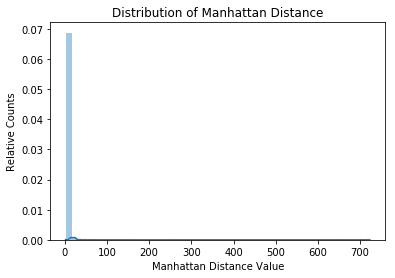

In [54]:
sns.distplot(manhattan)
plt.title('Distribution of Manhattan Distance')
plt.ylabel('Relative Counts')
plt.xlabel('Manhattan Distance Value')
plt.show()

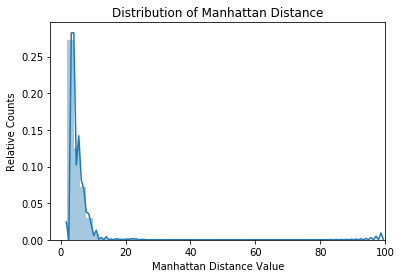

In [55]:
xhigh = 100
sns.distplot(list(filter(lambda x: x <xhigh, manhattan)))
plt.xlim(xmax=xhigh)
plt.title('Distribution of Manhattan Distance')
plt.ylabel('Relative Counts')
plt.xlabel('Manhattan Distance Value')
plt.show()

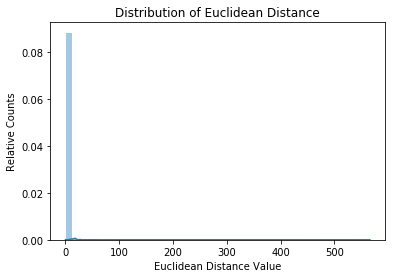

In [56]:
sns.distplot(euclidean)
plt.title('Distribution of Euclidean Distance')
plt.ylabel('Relative Counts')
plt.xlabel('Euclidean Distance Value')
plt.show()

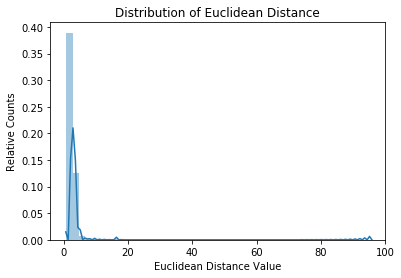

In [57]:
xhigh = 100
sns.distplot(list(filter(lambda x: x <xhigh, euclidean)))
plt.xlim(xmax=xhigh)
plt.title('Distribution of Euclidean Distance')
plt.ylabel('Relative Counts')
plt.xlabel('Euclidean Distance Value')
plt.show()

Now we have the distances, we can see which obervations are by definition outliers

In [58]:
manhattan_distance[:10]

[(722.8900448656699, 294060),
 (623.6023594686619, 22920),
 (543.996228951537, 376242),
 (521.5250177283924, 78803),
 (502.04004600786175, 180683),
 (450.55548856021187, 270464),
 (447.76437512488405, 616392),
 (434.6527191394313, 651202),
 (404.3098805904488, 315452),
 (399.3053501676543, 246250)]

In [59]:
euclidean_distance[:10]

[(565.6559338530689, 294060),
 (415.0566078482469, 376242),
 (404.2447364843658, 78803),
 (348.4347598492639, 22920),
 (312.30716220335154, 315452),
 (287.13768774487016, 180683),
 (248.25358077318293, 270464),
 (247.96040164210606, 651202),
 (247.93135833160605, 616392),
 (215.8736848868585, 447395)]

In [60]:
manhattan_rank = [e2 for e1,e2 in manhattan_distance]
euclidean_rank = [e2 for e1,e2 in euclidean_distance]

Let's examine how this to measures overlap by looking at the top 10

In [61]:
manhattan_rank[:15]

[294060,
 22920,
 376242,
 78803,
 180683,
 270464,
 616392,
 651202,
 315452,
 246250,
 508285,
 262368,
 210764,
 846614,
 97788]

In [62]:
euclidean_rank[:15]

[294060,
 376242,
 78803,
 22920,
 315452,
 180683,
 270464,
 651202,
 616392,
 447395,
 508285,
 246250,
 28608,
 81045,
 456014]

In [63]:
set(manhattan_rank[:10])^set(euclidean_rank[:10])

{246250, 447395}

In [64]:
manhattan_rank.index(447395)

19

As we can see, 9 in 10 are overlapped, whereas `246250` (ranked `12` in `euclidean_rank`) and `447395` (ranked `19` in `manhattan_rank`) does not match. 

Overall these two measurments agree with each other quite well.

# 3. Autoencoder

Here we try to use `autoencoder` to reconsruct our dataset. Since `autoencoder` learns from the whole dataset and tries to reconstruct a new dataset likewise, those observation that has higher `error` values are deeemed more abnormal than others. 

As for the intuitive explanation for `autoencoder`, I'll write it later if needed...

We use the normalized `data` from above.

In [12]:
data.shape

(1048575, 9)

Here we realize `autoencoder` with `keras`

In [13]:
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras import regularizers

In [14]:
from sklearn.model_selection import train_test_split
seed = 46
data_train, data_test = train_test_split(data, test_size=0.3, random_state=seed)

In [15]:
data_train.shape

(734002, 9)

In [16]:
data_test.shape

(314573, 9)

Here we have input dimension as `10`, and encoding dimension as `5`. Encoding dimension can be quite arbitrary, but our general idea is to reduce dimensionality to extract the `pattern` within the dataset, `input dimension/2` will do.

In [17]:
input_dim =data_train.shape[1]
encoding_dim = int(input_dim/2)

Next we build our autoencoder model with 1 input layer 2 encoders and 2 decoders.

In [18]:
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

Then we train fit our model with training set. 

Note that our main goal is not to completely reconstruct the dataset, but to generally reconstruct it and base on the error term to decide which observations are outliers. Thus, we don't need a deep neural network, nor thousands of eochs to converge. 

In [19]:
nb_epoch = 50
batch_size = 500
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
history = autoencoder.fit(data_train, data_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(data_test, data_test),
                    verbose=1)

Train on 734002 samples, validate on 314573 samples
Epoch 1/50
734002/734002 [==============================] - 7s - loss: 0.9265 - acc: 0.4044 - val_loss: 0.8174 - val_acc: 0.4822
Epoch 2/50
734002/734002 [==============================] - 7s - loss: 0.8098 - acc: 0.4829 - val_loss: 0.7943 - val_acc: 0.4766
Epoch 3/50
734002/734002 [==============================] - 5s - loss: 0.7983 - acc: 0.4942 - val_loss: 0.7887 - val_acc: 0.4945
Epoch 4/50
734002/734002 [==============================] - 6s - loss: 0.7940 - acc: 0.5006 - val_loss: 0.7853 - val_acc: 0.5013
Epoch 5/50
734002/734002 [==============================] - 5s - loss: 0.7910 - acc: 0.5074 - val_loss: 0.7929 - val_acc: 0.53880
Epoch 6/50
734002/734002 [==============================] - 4s - loss: 0.7902 - acc: 0.5126 - val_loss: 0.7816 - val_acc: 0.5059
Epoch 7/50
734002/734002 [==============================] - 5s - loss: 0.7882 - acc: 0.5173 - val_loss: 0.7806 - val_acc: 0.4960
Epoch 8/50
734002/734002 [==================

Let's visualize our model training history. We can see that both training and testing set converges at around 10 epochs.

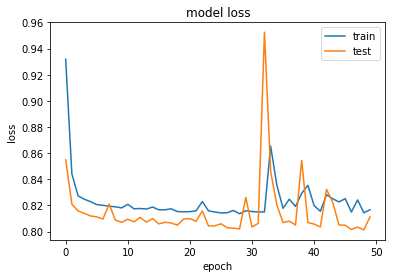

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

With the `autoencoder` fitted, we can reconstruct our data, and calculate the `error term`.

In [30]:
predictions = autoencoder.predict(data)

In [31]:
mse = np.mean(np.power(data - predictions, 2), axis=1)

In [104]:
#import pydot_ng as pydot

In [1]:
from keras.utils.vis_utils import plot_model

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [21]:
plot_model(autoencoder, to_file=path+'autoencoder.png',show_shapes=1)

Again, we check the distribution of `mse` to see if this measurement makes sense. The right skewed long tail graph still fits our expectation.

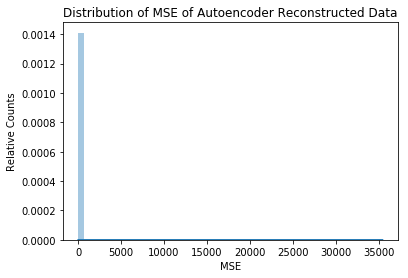

In [37]:
sns.distplot(mse)
plt.title('Distribution of MSE of Autoencoder Reconstructed Data')
plt.ylabel('Relative Counts')
plt.xlabel('MSE')
plt.show()

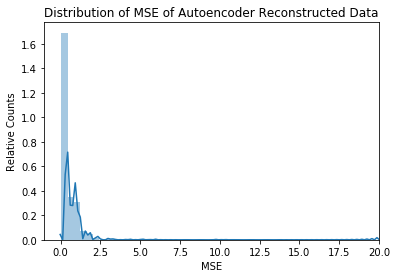

In [36]:
xhigh = 20
sns.distplot(list(filter(lambda x: x <xhigh, mse)))
plt.xlim(xmax=xhigh)
plt.title('Distribution of MSE of Autoencoder Reconstructed Data')
plt.ylabel('Relative Counts')
plt.xlabel('MSE')
plt.show()

And of course, we should compare the ranks. As we can see, top 10 in `euclidean_rank` is exactly top 10 in `autoencoder_rank`.

In [80]:
mse_sorted = sorted(zip(mse,np.arange(1048575)),reverse=1)

In [81]:
autoencoder_rank = [e2 for e1,e2 in mse_sorted]

In [82]:
autoencoder_rank[:15]

[294060,
 376242,
 78803,
 22920,
 315452,
 180683,
 270464,
 616392,
 651202,
 447395,
 508285,
 246250,
 888449,
 81045,
 28608]

In [85]:
set(euclidean_rank[:10])^set(autoencoder_rank[:10])

set()

# 4. Aggregation

Here we bin our scores, I'm too lazy too interpret what professor says. It's shown below.

--------------------分隔線-------------------------------

For each of the two scores,

1. Sort the records by the score. Bin them into equal bins, I suggest 1000 bins. Each bin will have about 1000 records in it.
2. Now, for all the records in the highest bin, replace the score by the number 1000. So the top, highest-scoring .1% of the records now all have the same score, 1000.
3. For the next bin, which is the next .1% highest scoring records, replace their score by the number 999. The second-highest .1% scoring records now all have the same score of 999.
4. Keep going, replacing the score value on the records by the bin number of where they are in the sorted order.

You have to do this separately for each of the scores. Now all the scores have been replaced by a 3-digit integer, the bin # for that record sorted by that score. Since you do this separately for each score, now each record has two different bin numbers, one from each score. These bin numbers are the new, scaled scores that can now be combined since they are scaled.

In [86]:
import math

In [87]:
bin_width = math.ceil(length/1000)

In [88]:
bin_score = np.repeat(np.arange(1,1001), bin_width)[::-1][:length]

In [89]:
manhattan_bin_score = sorted(zip(manhattan_rank,bin_score))
euclidean_bin_score = sorted(zip(euclidean_rank,bin_score))
autoencoder_bin_score = sorted(zip(autoencoder_rank,bin_score))

In [90]:
manhattan_bin_score[:10]

[(0, 78),
 (1, 215),
 (2, 664),
 (3, 979),
 (4, 1000),
 (5, 515),
 (6, 873),
 (7, 368),
 (8, 510),
 (9, 454)]

Now we have all scores prepared, time to load the original data and merge them

In [91]:
#yeah I know it;s super retarded to read excel file but I forgot to output original csv file so
#original_data = pd.read_excel(path.replace('project1','w2')+'NY property 1 million.xlsx')
#don't run this line if not necessary
#slow
original_data = pd.read_csv(path+'ny_property_with_outlier_scores.csv')

In [93]:
original_data = original_data.iloc[:,2:]

In [94]:
original_data['manhattan_score'] = [e2 for e1,e2 in manhattan_bin_score]
original_data['euclidean_score'] = [e2 for e1,e2 in euclidean_bin_score]
original_data['autoencoder_score'] = [e2 for e1,e2 in autoencoder_bin_score]

In [95]:
original_data.T.head(len(original_data.columns))

,0,1,2,3,4,5,6,7,8,9,...,1048565,1048566,1048567,1048568,1048569,1048570,1048571,1048572,1048573,1048574
BBLE,3046020035,5046820019,3074790028,4027980132,1006950027E,4031810007,4051861001,3082020064,4052570008,3070780050,...,1016767504,5024503210,5009450026,5017900100E,3053530059,3018100006,2039432739,1010381069,4015640031,3024950042
BLOCK,4602,4682,7479,2798,695,3181,5186,8202,5257,7078,...,1676,2450,945,1790,5353,1810,3943,1038,1564,2495
LOT,35,19,28,132,27,7,1001,64,8,50,...,7504,3210,26,100,59,6,2739,1069,31,42
EASEMENT,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,E,NaN,NaN,NaN,NaN,NaN,NaN
OWNER,DESMOND CAMPBELL,CINISOMO MARIO,GANGICHIODO DONALD,DCAS,CONRAIL,BERGERSON ERIC W,GOLDEN HUANG LLC,"SPICER, CLINTON",SILVIA SIPAVICIUS,ABHAS CHAUDHURI,...,NaN,ANTHONY FALCONE,ROBERT EDWARDS,NYC DEPT OF HIGHWAYS,"LORENTI, NORBERTO","309 TOMPKINS AVE.,",PARKCHESTER PRESERVAT,NaN,LUIS F JUELA,MANHATTAN AVE ASSOCS
BLDGCL,B1,A5,V0,V0,U6,A5,R5,B1,A1,C0,...,R0,R3,A1,Z7,C2,C2,R4,R4,B1,C1
TAXCLASS,1,1,1B,1B,3,1,4,1,1,1,...,2,1A,1,4,2A,2A,2,2,1,2
LTFRONT,18,25,16,21,0,20,0,24,40,24,...,75,0,40,30,23,25,0,0,25,50
LTDEPTH,100,100,19,75,0,100,0,100,96,100,...,75,0,96,311,125,100,0,0,100,95
STORIES,2,3,NaN,NaN,NaN,2,6,2,2,2,...,11,2,2,NaN,3,4,8,43,2.7,3


In [96]:
original_data.describe().T

,count,mean,std,min,25%,50%,75%,max
BLOCK,1048575.0,4708.867421,3.699547e+03,1.0,1534.0,3944.0,6797.00,1.635000e+04
LOT,1048575.0,370.092395,8.605382e+02,1.0,23.0,49.0,146.00,9.978000e+03
LTFRONT,1048575.0,36.174248,7.373356e+01,0.0,19.0,25.0,40.00,9.999000e+03
LTDEPTH,1048575.0,88.276429,7.547885e+01,0.0,80.0,100.0,100.00,9.999000e+03
STORIES,996433.0,5.063363,8.431372e+00,1.0,2.0,2.0,3.00,1.190000e+02
FULLVAL,1048575.0,880487.657847,1.170293e+07,0.0,303000.0,446000.0,619000.00,6.150000e+09
AVLAND,1048575.0,85995.027083,4.100755e+06,0.0,9160.0,13646.0,19706.00,2.668500e+09
AVTOT,1048575.0,230758.183174,6.951206e+06,0.0,18385.0,25339.0,46095.00,4.668309e+09
EXLAND,1048575.0,36811.788682,4.024330e+06,0.0,0.0,1620.0,1620.00,2.668500e+09
EXTOT,1048575.0,92543.814625,6.578281e+06,0.0,0.0,1620.0,2090.00,4.668309e+09


In [97]:
#to prevent the tragedy above, output as csv...
#it's not necessary
original_data.to_csv(path+'ny_property_with_outlier_scores.csv') 

Now we have to decide the weight of each score to reach an unanimous rank. 

Here I arbitrarily assign:

manhattan: 0.3
euclidean: 0.4
autoencoder: 0.3

In [98]:
def get_weighted_score(l):
    return(0.3*l[0]+0.4*l[1]+0.3*l[2])

In [99]:
original_data['weighted_score'] = original_data.iloc[:,-3:].apply(func = get_weighted_score,axis=1)

In [100]:
original_data.iloc[:10,-1]

0     142.5
1     245.3
2     719.1
3     899.0
4    1000.0
5     396.3
6     781.3
7     389.6
8     410.9
9     415.0
Name: weighted_score, dtype: float64

We output those observations with `weighted_score` = `1000`

In [104]:
weird = original_data[original_data['weighted_score'] == 1000]

In [105]:
len(weird)

669

In [106]:
weird.T.head(len(weird.columns))

,4,481,2502,4631,5502,8105,8170,9692,11984,11991,...,1037273,1037511,1038375,1038862,1041400,1042568,1044063,1047068,1048161,1048228
BBLE,1006950027E,1012651109,1012830021,1012820030E,1012651096,1000060001E,4158510048F,4158530060H,1010690008E,1010770029E,...,1012910010,1000161302,1012651060,1012800010G,4065170001,1012651028,1012760058,4158520073G,1009360045E,1012651066
BLOCK,695,1265,1283,1282,1265,6,15851,15853,1069,1077,...,1291,16,1265,1280,6517,1265,1276,15852,936,1265
LOT,27,1109,21,30,1096,1,48,60,8,29,...,10,1302,1060,10,1,1028,58,73,45,1066
EASEMENT,E,NaN,NaN,E,NaN,E,F,H,E,E,...,NaN,NaN,NaN,G,NaN,NaN,NaN,G,E,NaN
OWNER,CONRAIL,NBC TRUST NO. 1996A,MIDTOWN TRACKAGE VENT,PENN CENTRAL RAILROAD,NBC TRUST NO. 1996A,DEPT OF PARKS AND REC,CITY OF NEW YORK,NaN,CONSOLIDATED RAIL CO,NaN,...,550 MADISON AVENUE TR,NaN,RCPI LANDMARK PROPERT,PENN CENTRAL RAILROAD,NEW YORK STATE OWNED,RCPI LANDMARK PROPERT,BFP 300 MADISON II LL,CITY OF NEW YORK,NATIONAL PASS RR CORP,RCPI LANDMARK PROPERT
BLDGCL,U6,R5,O4,U1,R5,Z7,U1,U1,U6,U6,...,O4,R5,R5,U1,W5,R5,O3,U1,U6,R5
TAXCLASS,3,4,4,3,4,4,3,3,3,3,...,4,4,4,3,4,4,4,3,3,4
LTFRONT,0,0,200,0,0,191,0,0,0,0,...,189,0,0,0,16,0,254,0,0,0
LTDEPTH,0,0,400,0,0,349,0,0,0,0,...,201,0,0,0,1660,0,197,0,0,0
STORIES,NaN,70,52,NaN,70,NaN,NaN,NaN,NaN,NaN,...,35,14,70,NaN,3,70,38,NaN,NaN,70


In [107]:
weird.to_csv(path+'weird.csv')

Last, we should examine why these observations are "weird". Let's take the top 10 scorers in `euclidean_rank` for example.

In [108]:
euclidean_rank[:10]

[294060, 376242, 78803, 22920, 315452, 180683, 270464, 651202, 616392, 447395]

In [109]:
weird.loc[euclidean_rank[:10]].T

,294060,376242,78803,22920,315452,180683,270464,651202,616392,447395
BBLE,1011110001,4142600001,3085900700,4059170001,4009260001,4084890001,1000160140,1000160225,1000160120,3085910100
BLOCK,1111,14260,8590,5917,926,8489,16,16,16,8591
LOT,1,1,700,1,1,1,140,225,120,100
EASEMENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OWNER,CULTURAL AFFAIRS,"LOGAN PROPERTY, INC.",U S GOVERNMENT OWNRD,THE CITY OF NEW YORK,NEW YORK STATE DEPART,NORTH SHORE TOWERS AP,AMERICAN EXPRESS CO,BATTERY PARK CITY AUT,WFP TOWER A CO. L.P.,DEPT OF GENERAL SERVI
BLDGCL,Q1,T1,V9,V3,T1,D4,O4,O4,O4,V9
TAXCLASS,4,4,4,1B,4,2,4,4,4,4
LTFRONT,840,4910,117,2000,3030,950,187,286,468,466
LTDEPTH,0,0,108,2200,5948,200,250,174,213,1009
STORIES,NaN,3,NaN,NaN,1,33,50,17,39,NaN


Guess we can discuss why they are outliers... at least I don't see something evident

In [110]:
original_data.iloc[:,-4:].to_csv('scores.csv')

In [112]:
from collections import Counter

In [113]:
Counter(weird['STADDR']).most_common()

[('30 ROCKEFELLER PLAZA', 109),
 (nan, 36),
 ('11 AVENUE', 16),
 ('EAST 33 STREET', 14),
 ('EAST 42 STREET', 13),
 ('ROCKAWAY BEACH BLVD', 13),
 ('BORDEN AVENUE', 12),
 ('PARK AVENUE', 10),
 ('BROADWAY', 9),
 ('RIVERSIDE DRIVE', 8),
 ('10 AVENUE', 8),
 ('12 AVENUE', 7),
 ('EDGEMERE AVENUE', 6),
 ('SILVER BEACH', 6),
 ('2 RIVER TERRACE', 5),
 ('EAST 30 STREET', 5),
 ('WEST 32 STREET', 5),
 ('QUEENS BOULEVARD', 4),
 ('EAST 45 STREET', 4),
 ('RIVERSIDE PARK', 4),
 ('WEST 31 STREET', 4),
 ('1 AVENUE', 4),
 ('7 AVENUE', 4),
 ('159 STREET', 4),
 ('LEXINGTON AVENUE', 4),
 ('WEST 30 STREET', 4),
 ('FLATBUSH AVENUE', 3),
 ('2 AVENUE', 3),
 ('MADISON AVENUE', 3),
 ('SEAGIRT BOULEVARD', 3),
 ('WEST 36 STREET', 3),
 ('109 AVENUE', 3),
 ('102 NORTH END AVENUE', 3),
 ('COLUMBIA HEIGHTS', 3),
 ('WEST 38 STREET', 3),
 ('BEACH 42 STREET', 2),
 ('80 WEST 225 STREET', 2),
 ('399 PARK AVENUE', 2),
 ('WEST 155 STREET', 2),
 ('WEST 37 STREET', 2),
 ('EAST 127 STREET', 2),
 ('26 COURT STREET', 2),
 ('WEST 42

In [114]:
Counter(weird['OWNER']).most_common()

[(nan, 84),
 ('CITY OF NEW YORK', 72),
 ('NBC TRUST NO. 1996A', 54),
 ('RCPI LANDMARK PROPERT', 53),
 ('CNY/NYCTA', 26),
 ('NATIONAL PASS RR CORP', 24),
 ('PENN CENTRAL RAILROAD', 20),
 ('CONSOLIDATED RAIL CO', 19),
 ('CONRAIL', 13),
 ('PARKS AND RECREATION', 13),
 ('EDGEWATER PARK OWNRSE', 9),
 ('DEPT RE-CITY OF NY', 8),
 ('LIRR', 7),
 ('CONRAIL CORP', 6),
 ('SILVER BEACH GARDENS', 6),
 ('NYC DEPT OF HIGHWAYS', 6),
 ('PENN CENTRAL', 6),
 ('RCPI 30 ROCK 22234849', 6),
 ('NYC & HRR CO', 5),
 ('CNY/TBTA', 5),
 ('EDGEWATER PK OWNERS C', 5),
 ('THE CITY OF NEW YORK', 4),
 ('ELI ACQUISITION LLC', 4),
 ('DEPT OF GENERAL SERVI', 3),
 ('PENN CENTRAL RR', 3),
 ('CITY OF NY BORO PRES', 3),
 ('DEPARTMENT OF BUSINES', 3),
 ('UNITED STATES OF AMER', 3),
 ('PRESBYTERIAN HSP CITY', 2),
 ('NYC DEPT PUBLIC WORKS', 2),
 ('U S GOVERNMENT OWNRD', 2),
 ('BP 399 PARK AVENUE,', 2),
 ('DORMITORY AUTHORITY O', 2),
 ('CON EDISON', 2),
 ('YILDIZ HOLDING A.S.', 2),
 ('N Y C --TUNNEL', 2),
 ('BATTERY PARK CITY AUT

In [117]:
data_transformed = pd.read_csv(path+'data_newvariables.csv')

In [118]:
data_transformed.loc[euclidean_rank[:10]].T

,294060,376242,78803,22920,315452,180683,270464,651202,616392,447395
Unnamed: 0,294061.000000,376243.000000,78804.000000,22921.000000,315453.000000,180684.000000,270465.000000,651203.000000,616393.000000,447396.000000
FULLVAL,525.434322,31.884280,369.601828,23.822214,451.008497,27.781043,33.933350,7.871493,25.217581,197.386834
AVLAND,650.712812,437.168967,474.729784,4.071009,83.817244,11.611033,9.372421,2.876057,16.329676,253.565946
AVTOT,398.099157,671.549397,280.038588,2.380803,341.713258,21.071055,25.732116,5.987341,19.128946,149.566440
NA_COUNT_PRE,-2.418622,-3.078735,-1.758510,0.221827,-2.418622,-3.078735,-2.418622,-2.418622,-2.418622,-1.758510
NA_COUNT_POST,-2.683409,-2.683409,-2.683409,-2.683409,-2.683409,-0.750185,-0.750185,-0.750185,-0.750185,-2.683409
FULLVAL_LTAREA_zip5,3.223128,-0.911605,0.273146,-1.298859,-1.215754,13.482292,37.947758,37.947758,37.947758,0.273146
FULLVAL_BLDAREA_zip5,1.284960,-0.002757,0.825740,710.573983,2.547374,29.996849,47.955802,47.955802,47.955802,0.825740
FULLVAL_VOLUME_zip5,-0.461576,0.257713,0.503424,462.390507,1.301265,0.349375,0.819442,0.819442,0.819442,0.503424
AVLAND_LTAREA_zip5,3.510803,-0.480247,0.746742,-0.524568,-0.076495,19.891305,46.925182,46.925182,46.925182,0.746742
